In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=36):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = ResNet(BasicBlock, [3, 4, 6, 3])


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_path = 'C:\\Users\\srisa\\Downloads\\102flowers\\Flower'
dataset = datasets.ImageFolder(root=data_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
sample_image, _ = next(iter(train_loader))  # Select a sample image


Feature map from layer 1


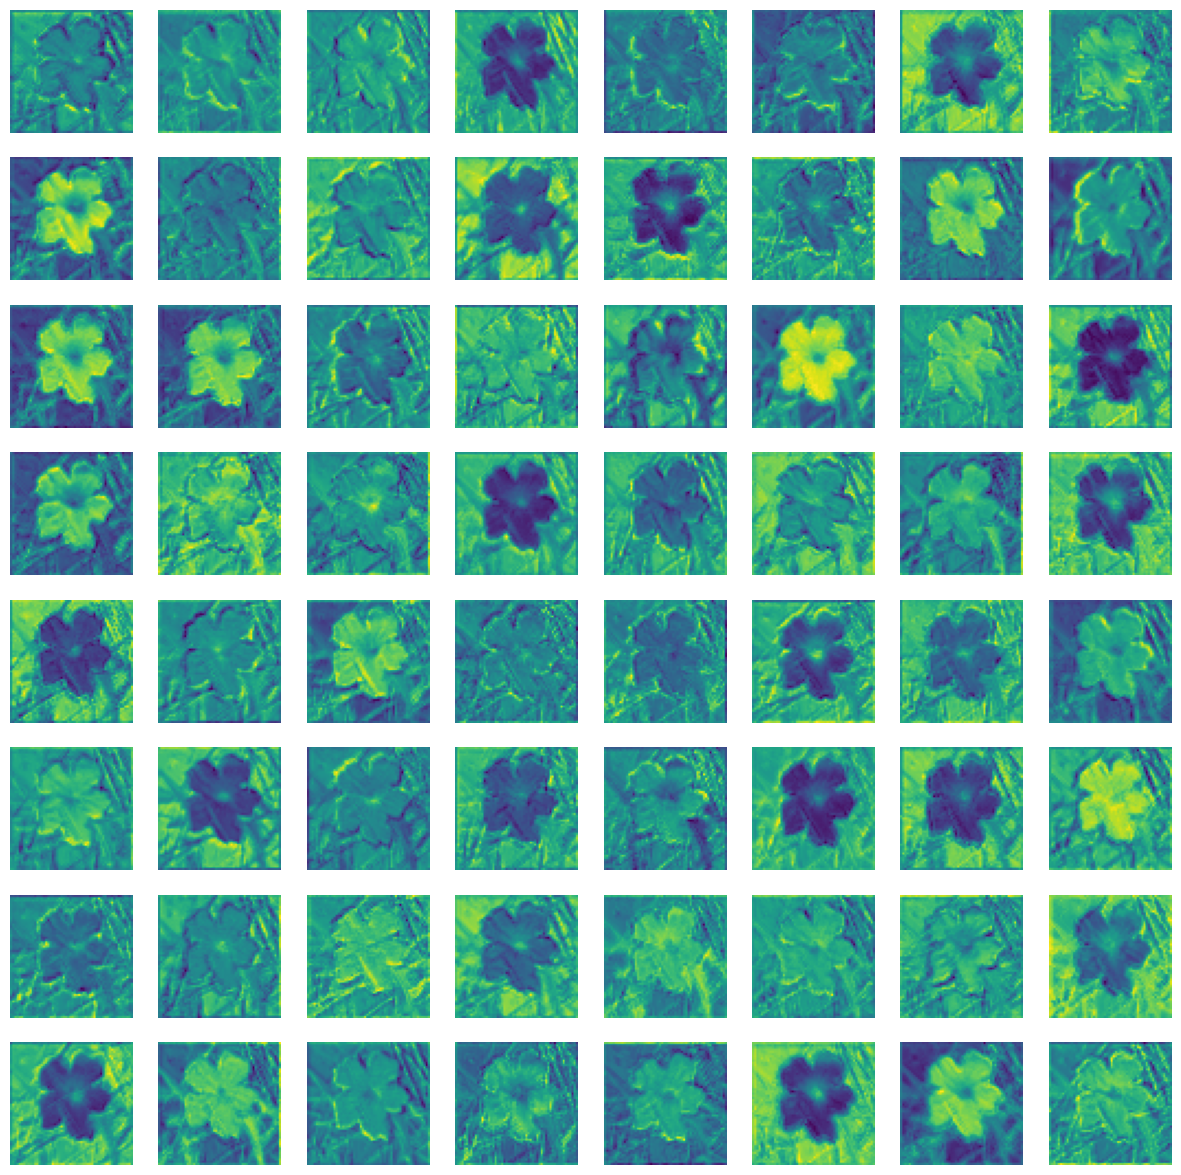

Feature map from layer 2


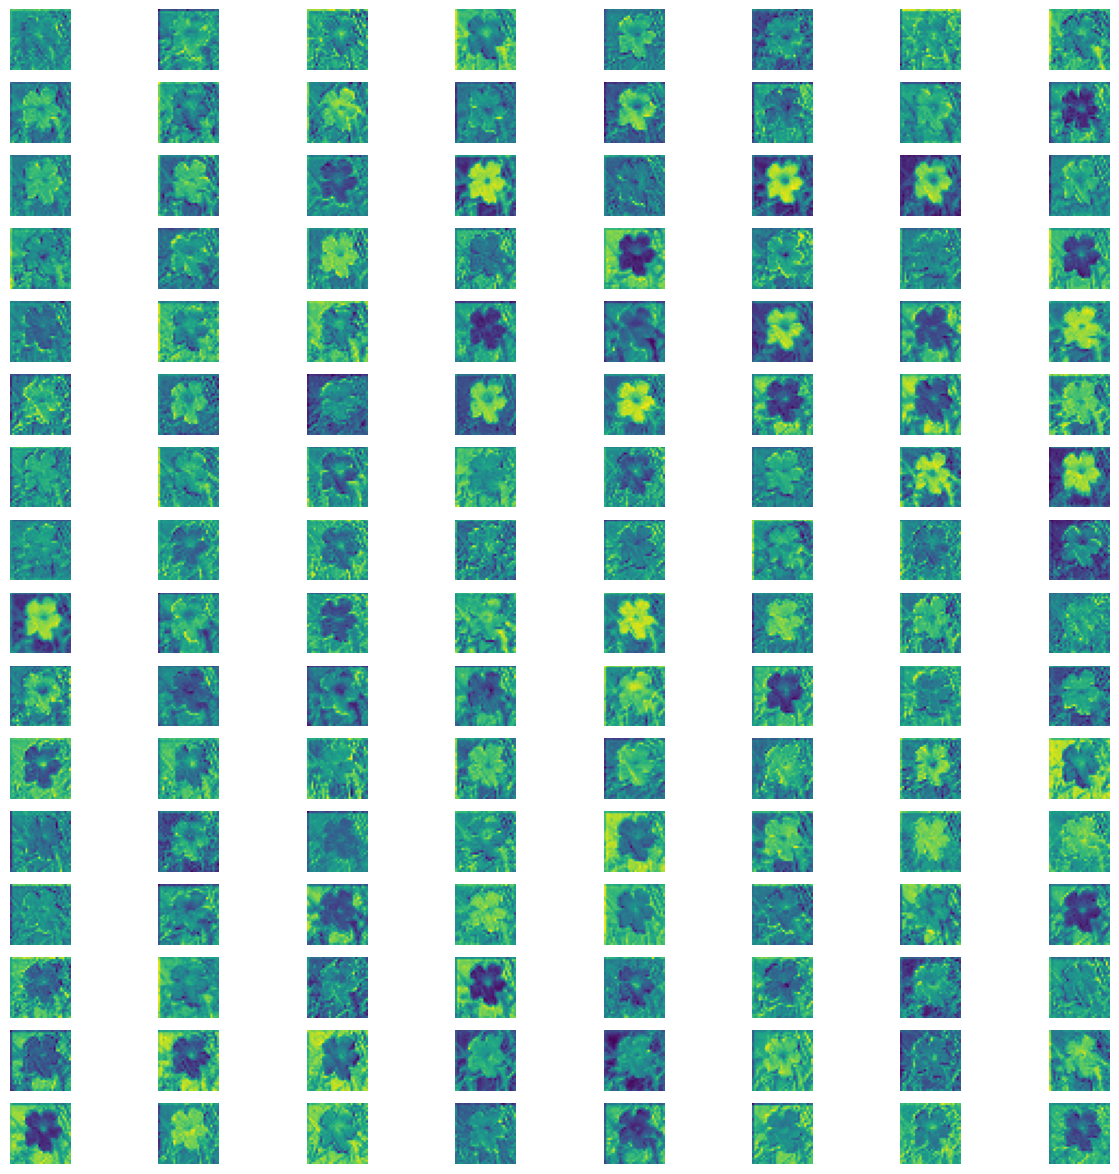

Feature map from layer 3


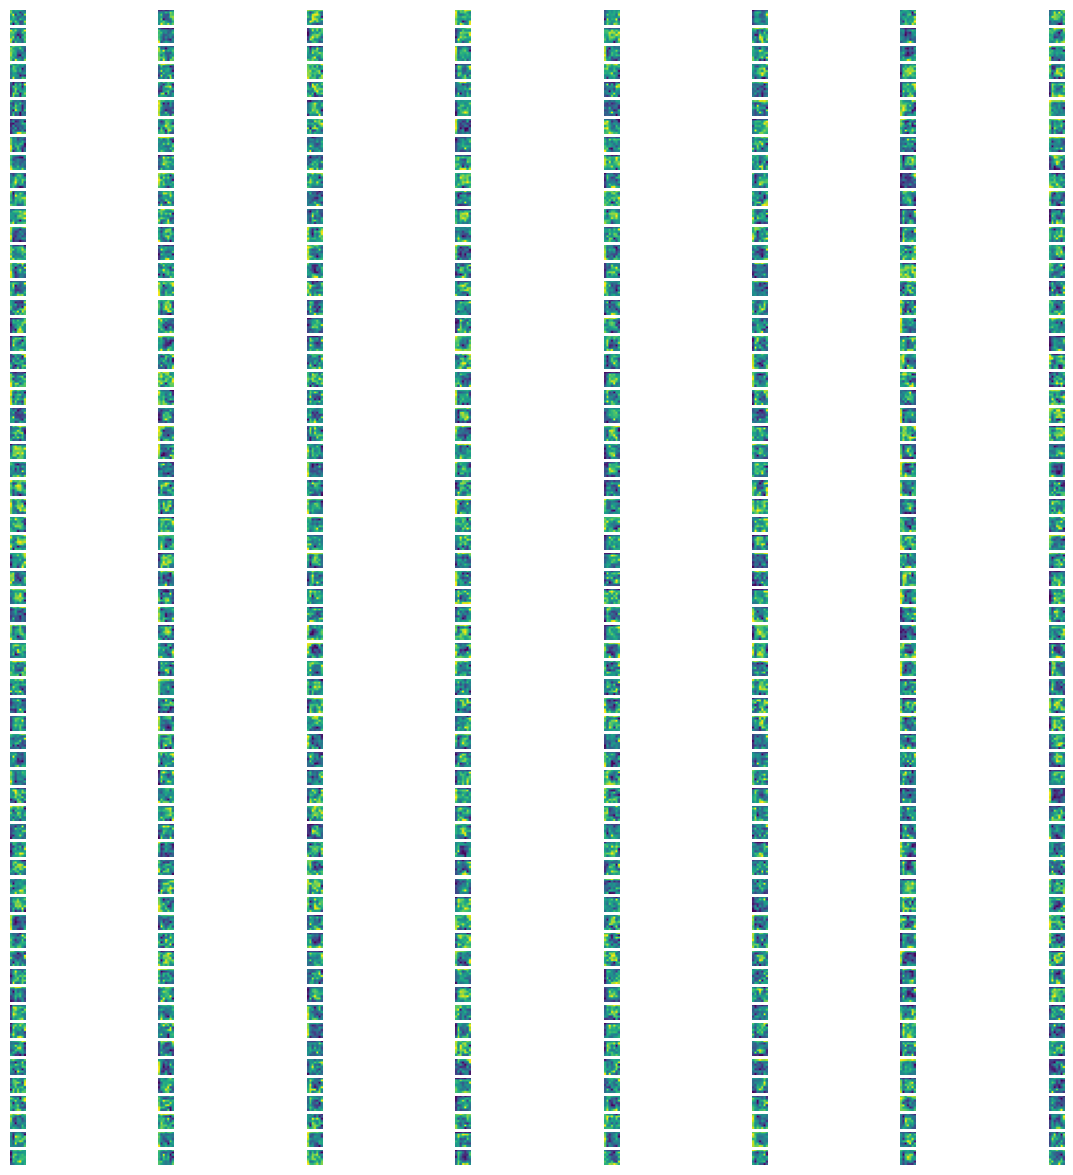

In [5]:
conv_outputs = []

def conv_hook(module, input, output):
    conv_outputs.append(output)

# Register hooks to specific layers
model.layer1[0].conv1.register_forward_hook(conv_hook)  # Early layer
model.layer2[0].conv1.register_forward_hook(conv_hook)  # Middle layer
model.layer4[0].conv1.register_forward_hook(conv_hook)  # Late layer

# Forward pass with the sample image
model.eval()
with torch.no_grad():
    _ = model(sample_image)

# Define visualization function for feature maps
def visualize_feature_maps(feature_maps, num_columns=8):
    num_feature_maps = feature_maps.shape[1]
    num_rows = (num_feature_maps + num_columns - 1) // num_columns
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 15))
    for i in range(num_rows * num_columns):
        if i < num_feature_maps:
            axs[i // num_columns, i % num_columns].imshow(feature_maps[0, i].cpu().detach().numpy(), cmap='viridis')
            axs[i // num_columns, i % num_columns].axis('off')
        else:
            axs[i // num_columns, i % num_columns].axis('off')
    plt.show()

# Visualize the feature maps from selected layers
for idx, feature_map in enumerate(conv_outputs):
    print(f"Feature map from layer {idx+1}")
    visualize_feature_maps(feature_map)


Activation map from layer 1


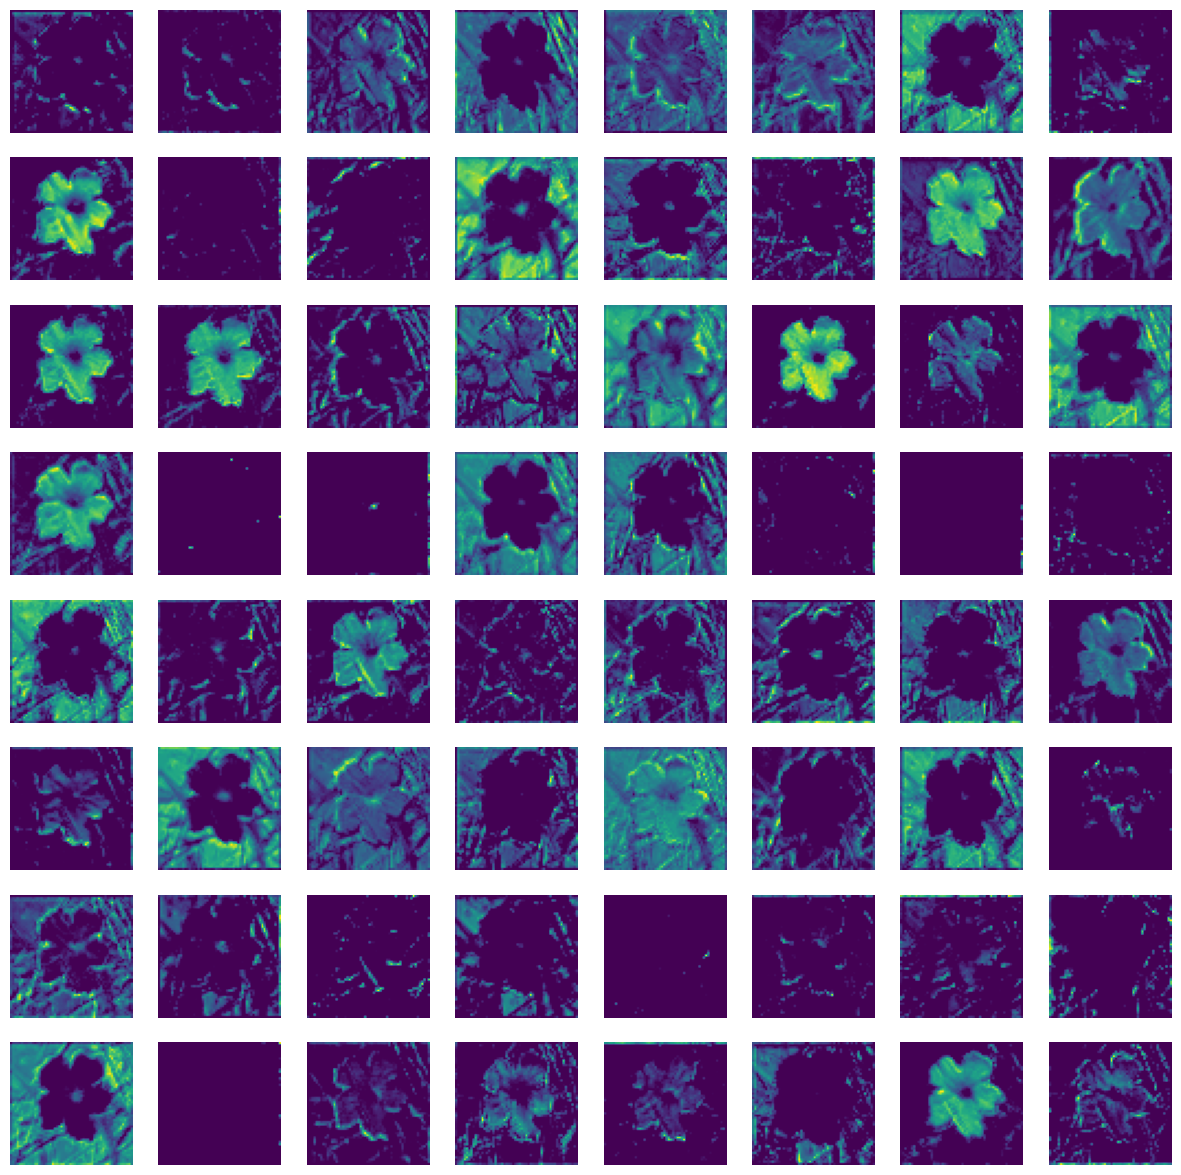

Activation map from layer 2


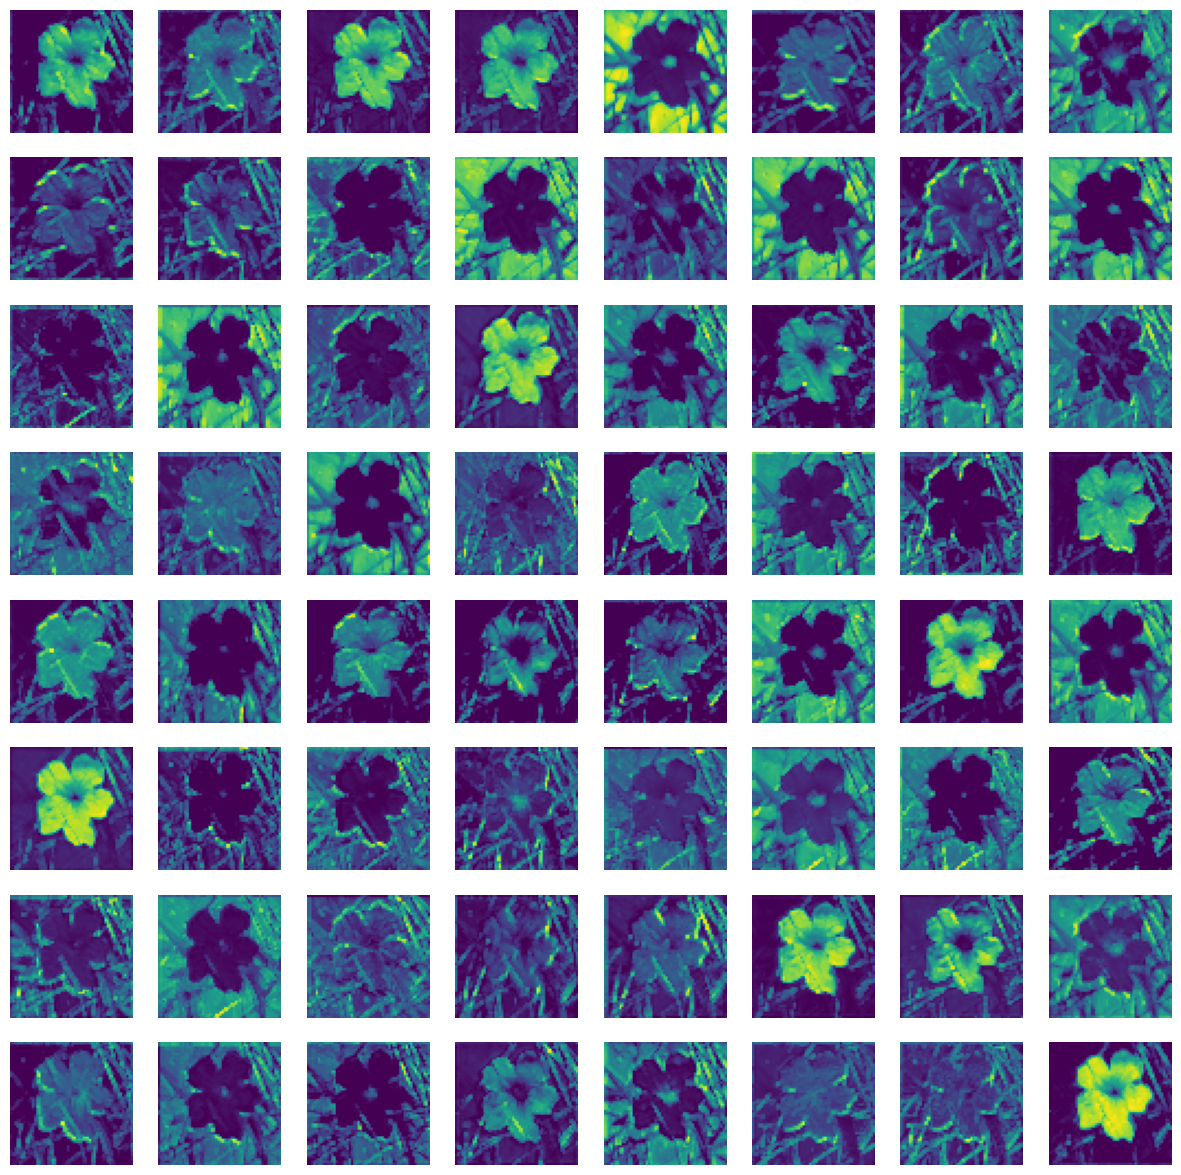

Activation map from layer 3


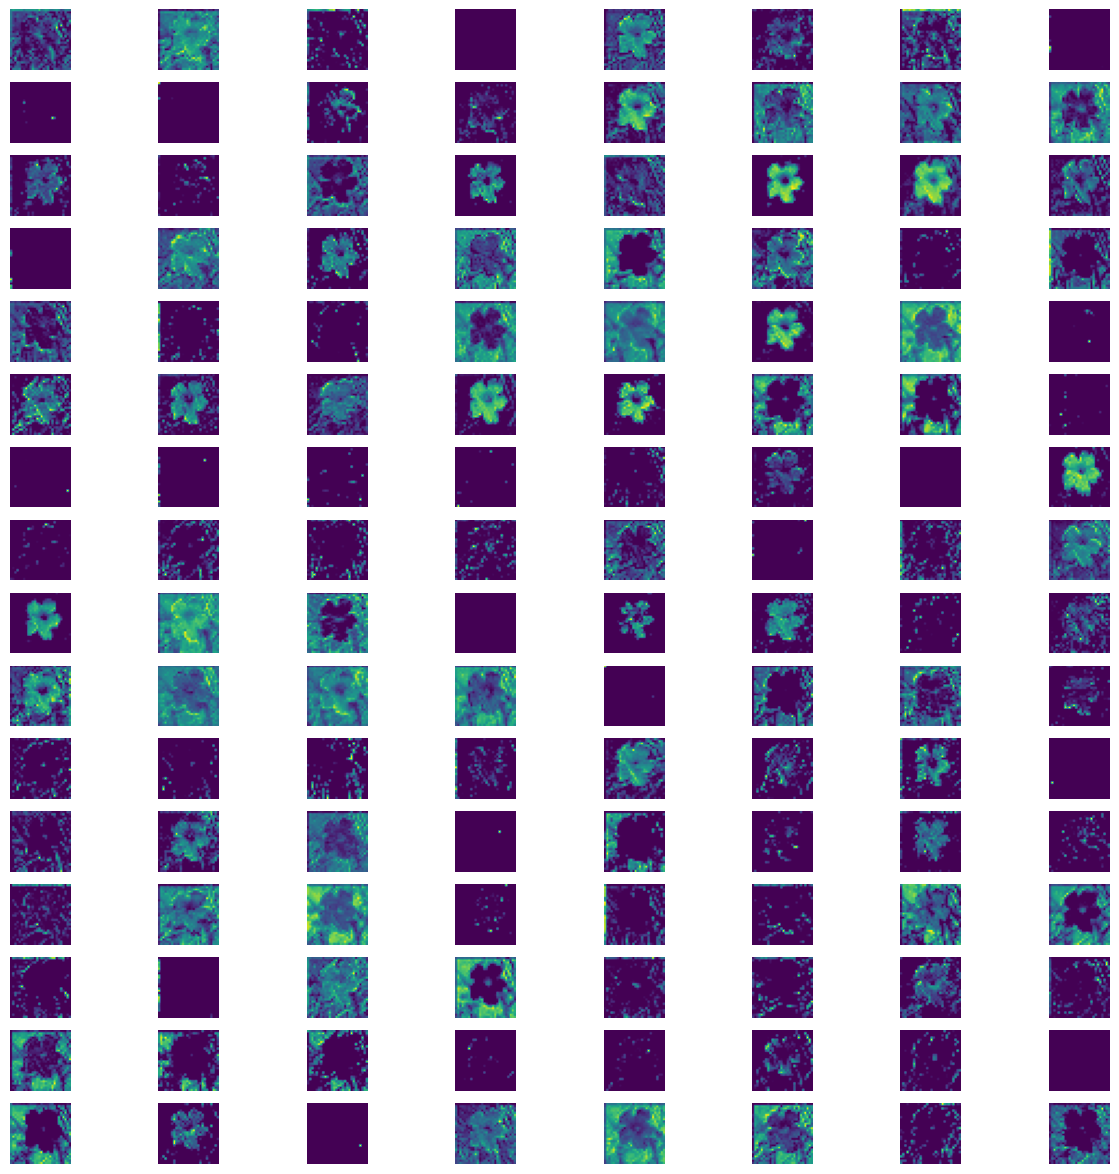

Activation map from layer 4


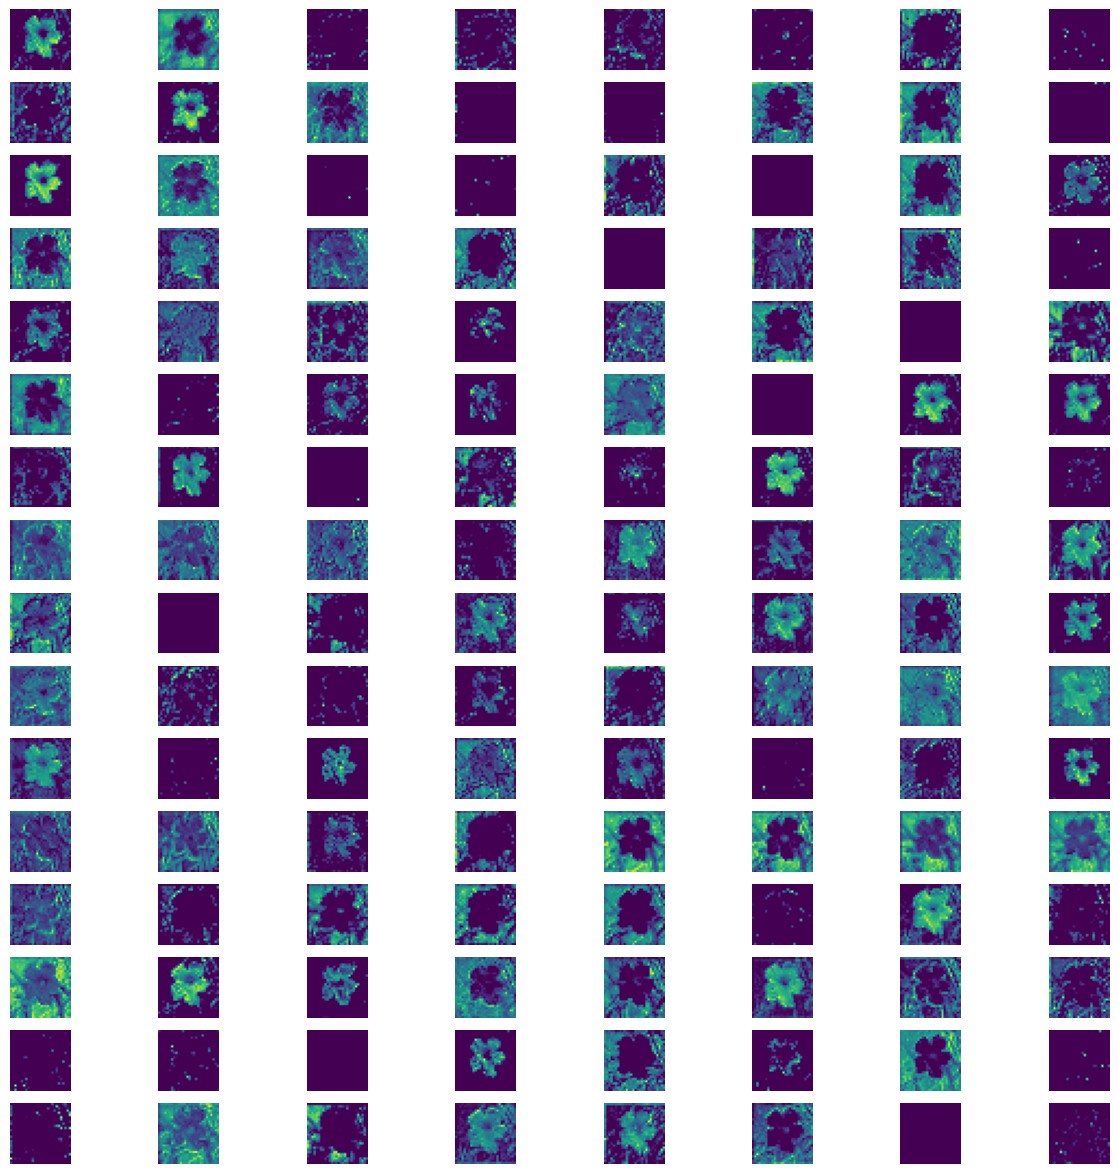

Activation map from layer 5


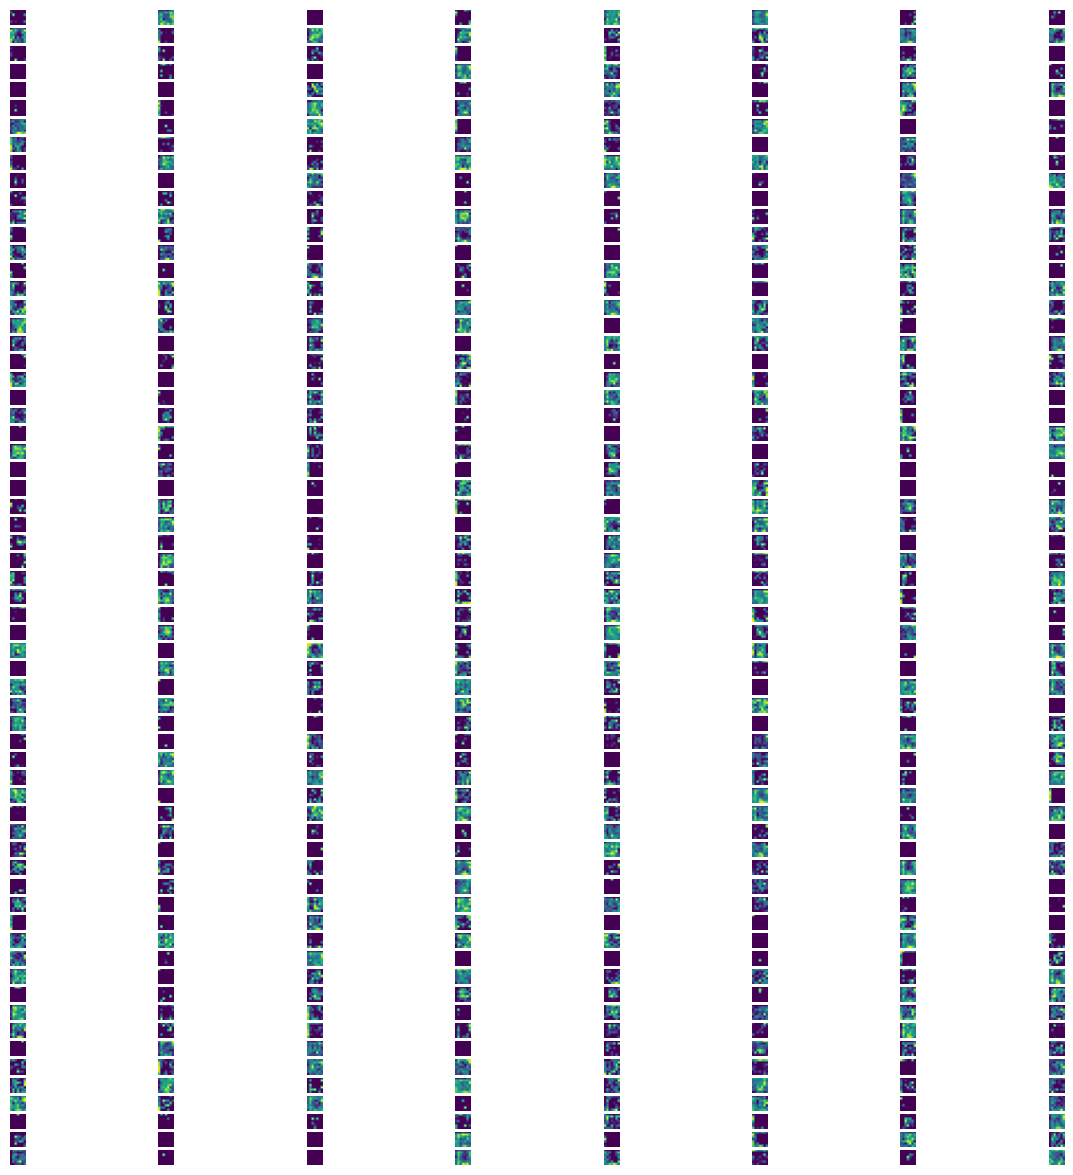

Activation map from layer 6


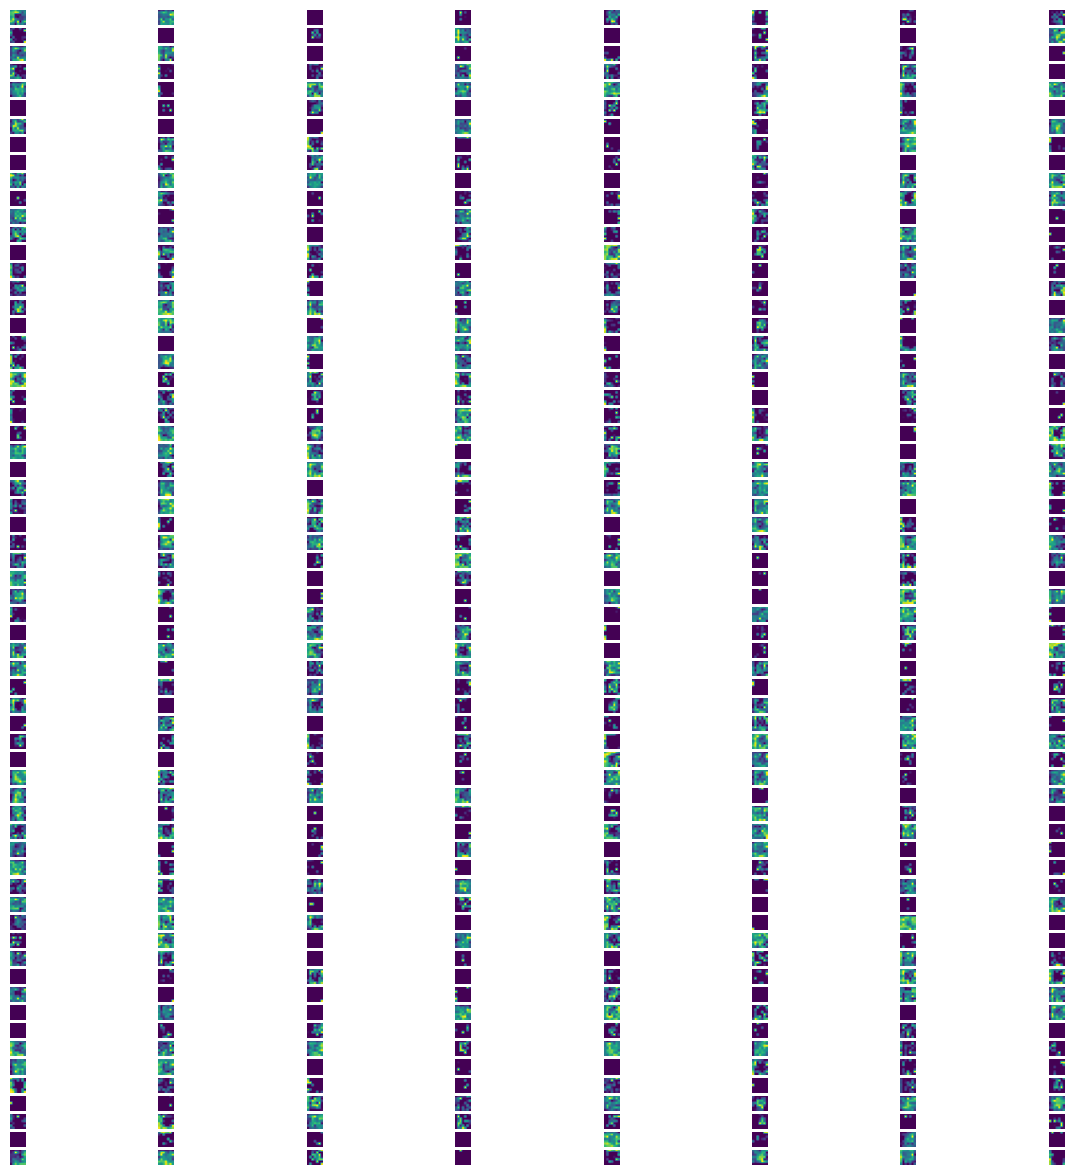

In [6]:
activation_outputs = []

def activation_hook(module, input, output):
    activation_outputs.append(output)

# Register hooks to specific ReLU layers
model.layer1[0].relu.register_forward_hook(activation_hook)  # Early ReLU
model.layer2[0].relu.register_forward_hook(activation_hook)  # Middle ReLU
model.layer4[0].relu.register_forward_hook(activation_hook)  # Late ReLU

# Forward pass with the sample image
activation_outputs.clear()
model.eval()
with torch.no_grad():
    _ = model(sample_image)

# Visualize the activations from selected ReLU layers
for idx, activation in enumerate(activation_outputs):
    print(f"Activation map from layer {idx+1}")
    visualize_feature_maps(activation)


Visualizing weights from the first convolutional layer:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08114447..0.08208476].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.080447696..0.08175638].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08095726..0.0824742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07947906..0.08246586].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08116684..0.081767485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08164896..0.08217017].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got ran

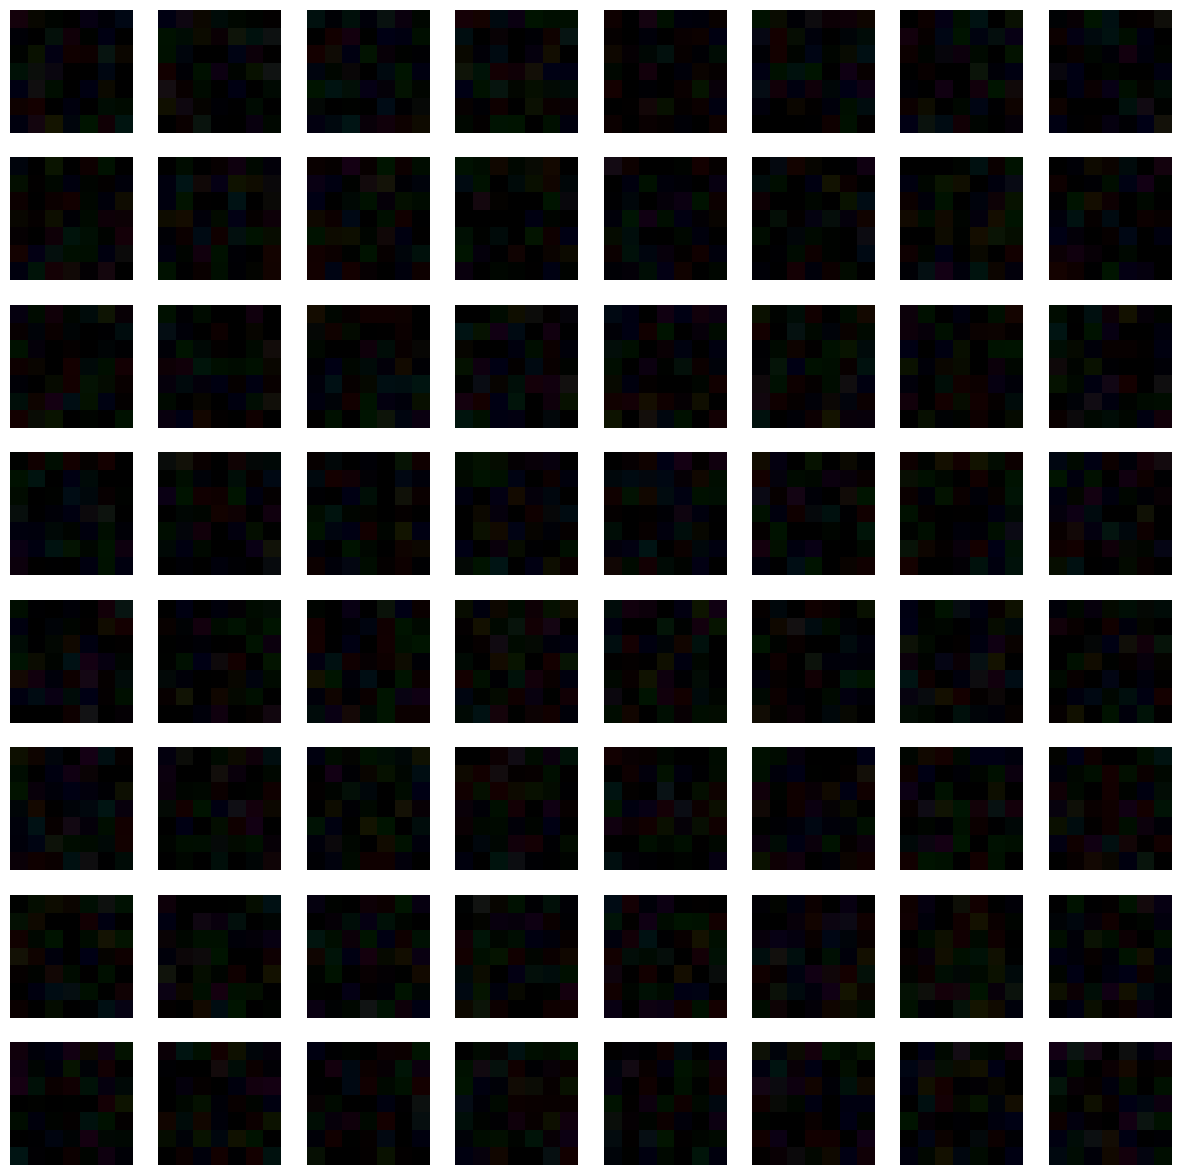

In [7]:
conv1_weights = model.conv1.weight.data

def visualize_weights(weights, num_columns=8):
    num_weights = weights.shape[0]
    num_rows = (num_weights + num_columns - 1) // num_columns
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 15))
    for i in range(num_rows * num_columns):
        if i < num_weights:
            axs[i // num_columns, i % num_columns].imshow(weights[i].cpu().numpy().transpose(1, 2, 0))
            axs[i // num_columns, i % num_columns].axis('off')
        else:
            axs[i // num_columns, i % num_columns].axis('off')
    plt.show()

# Visualize the weights in the first convolutional layer
print("Visualizing weights from the first convolutional layer:")
visualize_weights(conv1_weights)
